# Simulated E. coli and Combined Sewer Overflow (CSO) Peak Analysis
This notebook generates a journal-quality time series plot of E. coli at four sites and CSO discharges, with clear annotation of peak values.

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


## Load and Prepare Data

In [74]:
# File path
file_path = r"C:\Users\asaharia\Work\Other\EColi_Paper\Data\CSOs_Data.xlsx"
# Read Excel data (first sheet assumed)
data = pd.read_excel(file_path)
# Ensure the date column is in datetime format
if not pd.api.types.is_datetime64_any_dtype(data['Date']):
    data['Date'] = pd.to_datetime(data['Date'])


## Subset Data to Desired Range and Create Custom Ticks

In [75]:
start_date = pd.Timestamp('2020-04-01')
end_date = pd.Timestamp('2020-12-01')
mask = (data['Date'] >= start_date) & (data['Date'] <= end_date)
plot_data = data.loc[mask].reset_index(drop=True)
# X-ticks at the specified dates
custom_ticks = [
    pd.Timestamp('2020-04-01'),
    pd.Timestamp('2020-06-01'),
    pd.Timestamp('2020-08-01'),
    pd.Timestamp('2020-10-01'),
    pd.Timestamp('2020-12-01')
]


## Set Up Y-Ticks and Find Peaks

In [76]:
custom_yticks = [0, 50, 100, 200, 500, 1000, 2000, 4000]
# Find peak E. coli across all locations
all_ecoli = pd.concat([
    plot_data['Ohio St'], plot_data['Downstream'], plot_data['Upstream'], plot_data['Midstream']], axis=1)
peak_ecoli_val = all_ecoli.max().max()
peak_ecoli_col = all_ecoli.max().idxmax()
peak_ecoli_idx = plot_data[peak_ecoli_col].idxmax()
peak_ecoli_date = plot_data.loc[peak_ecoli_idx, 'Date']
peak_ecoli_label = f"Peak E. coli ({peak_ecoli_val:.2f})"
arrow_offset_days = 18
peak_ecoli_annotate_date = peak_ecoli_date - pd.Timedelta(days=arrow_offset_days)
# Peak CSO (sum)
cso_sum = plot_data['6 CSOs cumec'] + plot_data['18CSOs cumec']
peak_cso_val = cso_sum.max()
peak_cso_idx = cso_sum.idxmax()
peak_cso_date = plot_data.loc[peak_cso_idx, 'Date']
peak_cso_label = f"Peak CSO ({peak_cso_val:.2f})"
peak_cso_annotate_date = peak_cso_date - pd.Timedelta(days=arrow_offset_days)
# Y-limits for axes
ecoli_ylim = max(all_ecoli.max()) * 1.8
cso_ylim = (plot_data['6 CSOs cumec'] + plot_data['18CSOs cumec']).max() + 6.5


## Generate the Plot

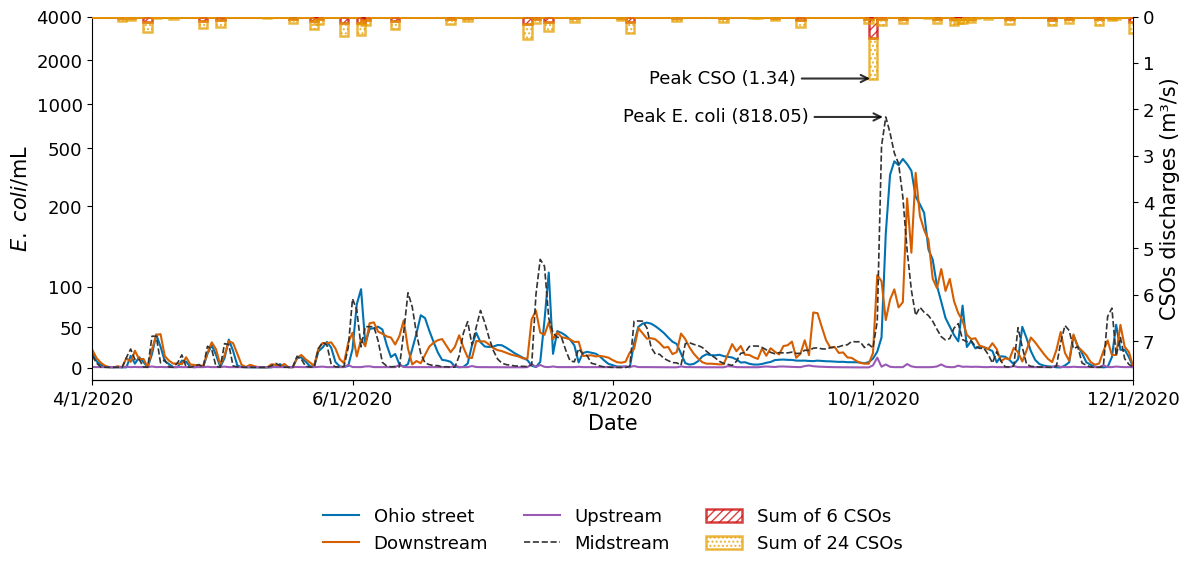

In [77]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# E. coli lines
ax1.plot(plot_data['Date'], plot_data['Ohio St'], label='Ohio street', color='#0072B2', lw=1.5)
ax1.plot(plot_data['Date'], plot_data['Downstream'], label='Downstream', color='#D55E00', lw=1.5)
ax1.plot(plot_data['Date'], plot_data['Upstream'], label='Upstream', color='#9B59B6', lw=1.5)  # distinct purple
ax1.plot(plot_data['Date'], plot_data['Midstream'], label='Midstream', color='#333333', lw=1.2, linestyle='--')

ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel(r'$\it{E.~coli}$/mL', fontsize=15, color='black')   # FIXED LABEL

ax1.set_yscale('symlog', linthresh=200)
ax1.set_yticks(custom_yticks)
ax1.set_yticklabels([str(y) for y in custom_yticks], fontsize=13)
ax1.set_xticks(custom_ticks)
ax1.set_xticklabels([d.strftime('%#m/%#d/%Y') for d in custom_ticks], fontsize=13)  # WINDOWS COMPATIBLE

ax1.set_xlim(start_date, end_date)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(axis='both', labelsize=13)

# Annotate peak E. coli (horizontal arrow, black label)
ax1.annotate(peak_ecoli_label,
             xy=(peak_ecoli_date, peak_ecoli_val),
             xytext=(peak_ecoli_annotate_date, peak_ecoli_val),
             arrowprops=dict(facecolor='#0072B2', arrowstyle='->', lw=1.5, alpha=0.8),
             fontsize=13, color='black', va='center', ha='right')

# CSO events
ax2 = ax1.twinx()
bar1 = ax2.bar(plot_data['Date'], plot_data['6 CSOs cumec'], label='Sum of 6 CSOs', color='none',
               edgecolor='#CC0000', linewidth=1.8, alpha=0.75, width=2, hatch='////')
bar2 = ax2.bar(plot_data['Date'], plot_data['18CSOs cumec'], bottom=plot_data['6 CSOs cumec'],
               label='Sum of 18 upstream CSOs', color='none', edgecolor='#E69F00',
               linewidth=1.8, alpha=0.75, width=2, hatch='....')
ax2.set_ylabel('CSOs discharges (m³/s)', fontsize=15, color='black')
ax2.set_ylim(0, cso_ylim)
ax2.invert_yaxis()
ax2.tick_params(axis='y', labelcolor='black', labelsize=13)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Annotate peak CSO (horizontal arrow, black label)
ax2.annotate(peak_cso_label,
             xy=(peak_cso_date, peak_cso_val),
             xytext=(peak_cso_annotate_date, peak_cso_val),
             arrowprops=dict(facecolor='#CC0000', arrowstyle='->', lw=1.5, alpha=0.8),
             fontsize=13, color='black', va='center', ha='right')

# Legend at the bottom, no overlap
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = [bar1, bar2], ['Sum of 6 CSOs', 'Sum of 24 CSOs']
plt.legend(lines1 + lines2, labels1 + labels2,
           loc='lower center', bbox_to_anchor=(0.5, -0.52),
           ncol=3, frameon=False, fontsize=13)

plt.subplots_adjust(bottom=0.50)
fig.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()
# Save as high-resolution PNG
fig.savefig("EColi_CSO_Peak_yr.png", dpi=400, bbox_inches='tight')


## Load and Prepare Data for year 2000

In [78]:
# File path
file_path = r"C:\Users\asaharia\Work\Other\EColi_Paper\Data\CSOs_Data_2000.xlsx"
# Read Excel data (first sheet assumed)
data = pd.read_excel(file_path)
# Ensure the date column is in datetime format
if not pd.api.types.is_datetime64_any_dtype(data['Date']):
    data['Date'] = pd.to_datetime(data['Date'])


## Subset Data to Desired Range and Create Custom Ticks

In [79]:
start_date = pd.Timestamp('2000-04-01')
end_date = pd.Timestamp('2000-12-01')
mask = (data['Date'] >= start_date) & (data['Date'] <= end_date)
plot_data = data.loc[mask].reset_index(drop=True)
# X-ticks at the specified dates
custom_ticks = [
    pd.Timestamp('2000-04-01'),
    pd.Timestamp('2000-06-01'),
    pd.Timestamp('2000-08-01'),
    pd.Timestamp('2000-10-01'),
    pd.Timestamp('2000-12-01')
]


## Set Up Y-Ticks and Find Peaks

In [80]:
custom_yticks = [0, 50, 100, 200, 500, 1000, 2000, 4000]
# Find peak E. coli across all locations
all_ecoli = pd.concat([
    plot_data['Ohio St'], plot_data['Downstream'], plot_data['Upstream'], plot_data['Midstream']], axis=1)
peak_ecoli_val = all_ecoli.max().max()
peak_ecoli_col = all_ecoli.max().idxmax()
peak_ecoli_idx = plot_data[peak_ecoli_col].idxmax()
peak_ecoli_date = plot_data.loc[peak_ecoli_idx, 'Date']
peak_ecoli_label = f"Peak E. coli ({peak_ecoli_val:.2f})"
arrow_offset_days = 18
peak_ecoli_annotate_date = peak_ecoli_date - pd.Timedelta(days=arrow_offset_days)
# Peak CSO (sum)
cso_sum = plot_data['6 CSOs cumec'] + plot_data['18CSOs cumec']
peak_cso_val = cso_sum.max()
peak_cso_idx = cso_sum.idxmax()
peak_cso_date = plot_data.loc[peak_cso_idx, 'Date']
peak_cso_label = f"Peak CSO ({peak_cso_val:.2f})"
peak_cso_annotate_date = peak_cso_date - pd.Timedelta(days=arrow_offset_days)
# Y-limits for axes
ecoli_ylim = max(all_ecoli.max()) * 1.8
cso_ylim = (plot_data['6 CSOs cumec'] + plot_data['18CSOs cumec']).max() + 6.5


## Generate the Plot

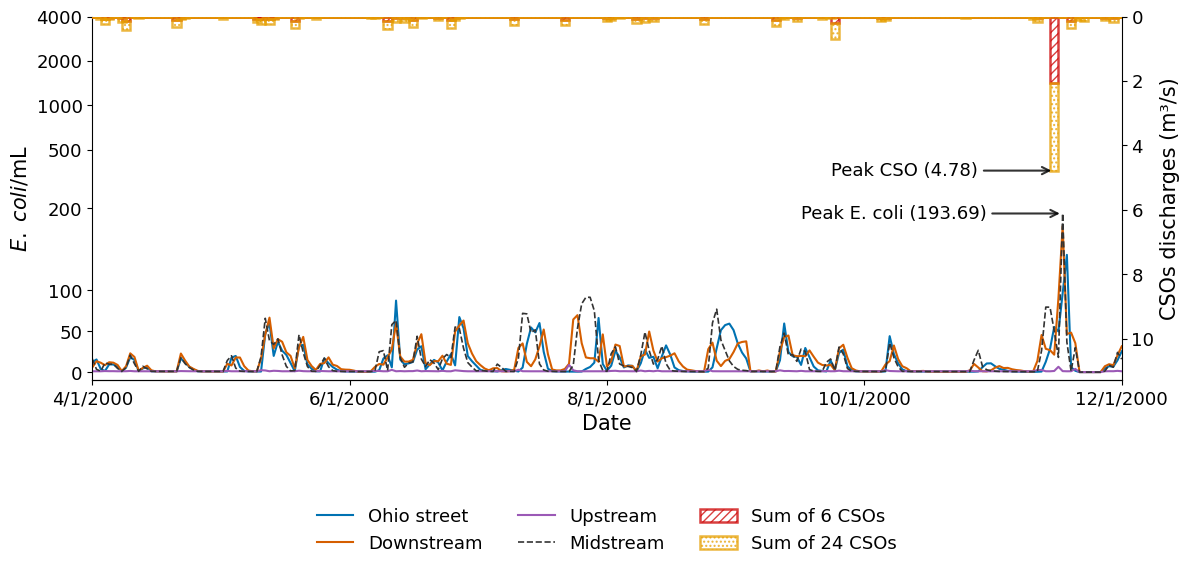

In [81]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# E. coli lines
ax1.plot(plot_data['Date'], plot_data['Ohio St'], label='Ohio street', color='#0072B2', lw=1.5)
ax1.plot(plot_data['Date'], plot_data['Downstream'], label='Downstream', color='#D55E00', lw=1.5)
ax1.plot(plot_data['Date'], plot_data['Upstream'], label='Upstream', color='#9B59B6', lw=1.5)  # distinct purple
ax1.plot(plot_data['Date'], plot_data['Midstream'], label='Midstream', color='#333333', lw=1.2, linestyle='--')

ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel(r'$\it{E.~coli}$/mL', fontsize=15, color='black')   # FIXED LABEL

ax1.set_yscale('symlog', linthresh=200)
ax1.set_yticks(custom_yticks)
ax1.set_yticklabels([str(y) for y in custom_yticks], fontsize=13)
ax1.set_xticks(custom_ticks)
ax1.set_xticklabels([d.strftime('%#m/%#d/%Y') for d in custom_ticks], fontsize=13)  # WINDOWS COMPATIBLE

ax1.set_xlim(start_date, end_date)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(axis='both', labelsize=13)

# Annotate peak E. coli (horizontal arrow, black label)
ax1.annotate(peak_ecoli_label,
             xy=(peak_ecoli_date, peak_ecoli_val),
             xytext=(peak_ecoli_annotate_date, peak_ecoli_val),
             arrowprops=dict(facecolor='#0072B2', arrowstyle='->', lw=1.5, alpha=0.8),
             fontsize=13, color='black', va='center', ha='right')

# CSO events
ax2 = ax1.twinx()
bar1 = ax2.bar(plot_data['Date'], plot_data['6 CSOs cumec'], label='Sum of 6 CSOs', color='none',
               edgecolor='#CC0000', linewidth=1.8, alpha=0.75, width=2, hatch='////')
bar2 = ax2.bar(plot_data['Date'], plot_data['18CSOs cumec'], bottom=plot_data['6 CSOs cumec'],
               label='Sum of 18 upstream CSOs', color='none', edgecolor='#E69F00',
               linewidth=1.8, alpha=0.75, width=2, hatch='....')
ax2.set_ylabel('CSOs discharges (m³/s)', fontsize=15, color='black')
ax2.set_ylim(0, cso_ylim)
ax2.invert_yaxis()
ax2.tick_params(axis='y', labelcolor='black', labelsize=13)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Annotate peak CSO (horizontal arrow, black label)
ax2.annotate(peak_cso_label,
             xy=(peak_cso_date, peak_cso_val),
             xytext=(peak_cso_annotate_date, peak_cso_val),
             arrowprops=dict(facecolor='#CC0000', arrowstyle='->', lw=1.5, alpha=0.8),
             fontsize=13, color='black', va='center', ha='right')

# Legend at the bottom, no overlap
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = [bar1, bar2], ['Sum of 6 CSOs', 'Sum of 24 CSOs']
plt.legend(lines1 + lines2, labels1 + labels2,
           loc='lower center', bbox_to_anchor=(0.5, -0.52),
           ncol=3, frameon=False, fontsize=13)

plt.subplots_adjust(bottom=0.50)
fig.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()
# Save as high-resolution PNG
fig.savefig("EColi_CSO_Peak_year2000.png", dpi=400, bbox_inches='tight')
